https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/convert/python_api.md

https://www.tensorflow.org/lite/microcontrollers/build_convert

1. Train model using Keras (simplest interface)
2. Convert to compressed floating point version using Tensorflow Lite
3. Optimise for more efficient integers
4. Deploy on Raspberry Pi

Possible Datasets:
https://www.kaggle.com/inIT-OWL/high-storage-system-data-for-energy-optimization,
https://www.kaggle.com/tocha4/predictive-maintenance-basics-about-dataset,
https://www.kaggle.com/inIT-OWL/one-year-industrial-component-degradation, http://odds.cs.stonybrook.edu/

Technique:
https://thingsolver.com/time-series-anomaly-detection-using-a-variational-autoencoder-vae/

## Setup

### Install Keras (which includes Tensorflow-gpu).
Note: TF 1.13 and above requires CUDA 10. If no NVidia GPU is available on your computer, install keras-cpu instead
- https://www.tensorflow.org/install/gpu
- https://developer.nvidia.com/cuda-10.1-download-archive

```
conda install keras-gpu
```

### Install other libraries (plotting, pre-processing):
```
conda install pandas matplotlib scikit-learn pydot
```

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Data Exploration

In [30]:
df = pd.read_csv('./../data/versatileproductionsystem/Filling_ALL.module.csv', index_col=0)
df.head()

,I_BottleAtAirpipe,I_BottleClampClose,I_BottleClampOpen,I_BottleGateClosed,I_BottleReserveGateClosed,I_BottlesAvailable,I_BottleSlot1,I_BottleSlot2_H2O,I_BottleSlot3_Corn,I_BottleSlot5_CapOn,...,BottlesAvailable.AnalogValue.EURangeViolation,BottleSlot1.AnalogValue.EURangeViolation,BottleSlot2_H2O.AnalogValue.EURangeViolation,BottleSlot3_Corn.AnalogValue.EURangeViolation,BottleSlot5_CapOn.AnalogValue.EURangeViolation,BottleSlot6_CapCloser.AnalogValue.EURangeViolation,BottleSlot8_ModuleOut.AnalogValue.EURangeViolation,BottlesNotUsed.AnalogValue.EURangeViolation,UltraSonic_Corn.DistanceM.EURangeViolation,UltraSonic_H2O.DistanceM.EURangeViolation
Timestamp,,,,,,,,,,,,,,,,,,,,,
1529500027127,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1529500027227,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1529500027327,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1529500027428,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1529500027528,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df.describe()

,I_BottleAtAirpipe,I_BottleClampClose,I_BottleClampOpen,I_BottleGateClosed,I_BottleReserveGateClosed,I_BottlesAvailable,I_BottleSlot1,I_BottleSlot2_H2O,I_BottleSlot3_Corn,I_BottleSlot5_CapOn,...,BottlesAvailable.AnalogValue.EURangeViolation,BottleSlot1.AnalogValue.EURangeViolation,BottleSlot2_H2O.AnalogValue.EURangeViolation,BottleSlot3_Corn.AnalogValue.EURangeViolation,BottleSlot5_CapOn.AnalogValue.EURangeViolation,BottleSlot6_CapCloser.AnalogValue.EURangeViolation,BottleSlot8_ModuleOut.AnalogValue.EURangeViolation,BottlesNotUsed.AnalogValue.EURangeViolation,UltraSonic_Corn.DistanceM.EURangeViolation,UltraSonic_H2O.DistanceM.EURangeViolation
count,10529.000000,10529.000000,10529.000000,10529.000000,10529.000000,10529.000000,10529.000000,10529.000000,10529.000000,10529.000000,...,10529.0,10529.0,10529.0,10529.0,10529.0,10529.0,10529.0,10529.0,10529.0,10529.0
mean,0.011207,0.254155,0.716497,0.973597,0.994871,0.973977,0.004274,0.688100,0.692089,0.712603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.105274,0.435406,0.450720,0.160339,0.071434,0.159212,0.065238,0.463291,0.461652,0.452570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# filter out low variance columns and plot them
high_variance_cols = df.columns[df.std() > 0.25]

high_variance_cols

Index(['I_BottleClampClose', 'I_BottleClampOpen', 'I_BottleSlot2_H2O',
       'I_BottleSlot3_Corn', 'I_BottleSlot5_CapOn', 'I_BottleSlot6_CapScrewer',
       'I_BottlesReserveAvailable', 'I_CapGrabberUp', 'I_CapScrewer_Up',
       'I_CapScrewerClosePos', 'I_CapScrewerGrabClosed', 'I_CapScrewerOpenPos',
       'I_LinAxisCapInGrabber', 'I_LinAxisDown', 'I_LinAxisEmptyGrabber',
       'I_LinAxisUp', 'I_Pump_Down', 'I_RotaryTablePosReached',
       'I_UltrasonicCorn', 'I_UltrasonicCorn_Distance',
       'I_UltrasonicH2O_Distance', 'O_BottleClampClose',
       'O_CapGrabberOpenClose', 'O_CapGrabberUpDown', 'O_CapScrewDown',
       'O_CapScrewerGrabberOpenClose', 'O_CloseCap', 'O_ConveyorCapsForward',
       'O_LinAxisUpDown', 'O_PumpUpDown', 'O_RotaryTable',
       'O_ValvePumpCloseOpen', 'PendingOrder', 'Rotating', 'State',
       'BottlesAvailable', 'BottleSlot1', 'BottleSlot2_H2O',
       'BottleSlot3_Corn', 'BottleSlot5_CapOn', 'BottleSlot6_CapCloser',
       'BottleSlot8_ModuleOut', 'B

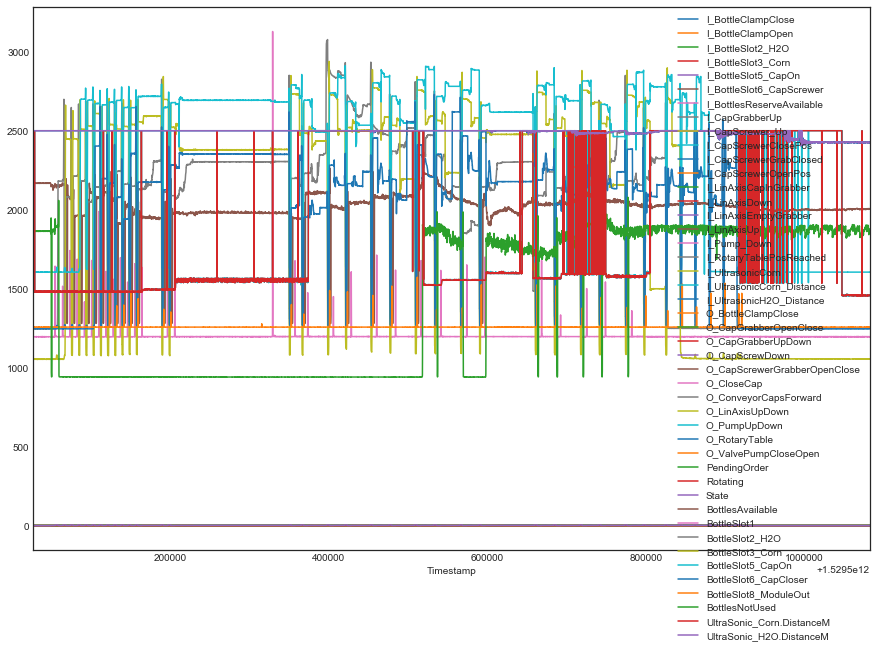

In [33]:
fig, ax = plt.subplots(figsize=(15, 10))
df[high_variance_cols].plot(ax=ax)
plt.show()

In [34]:
# There are still columns with low mean, let's plot them

df1 = df[high_variance_cols]
low_mean_cols = df1.columns[df1.mean() < 5]
low_mean_cols

Index(['I_BottleClampClose', 'I_BottleClampOpen', 'I_BottleSlot2_H2O',
       'I_BottleSlot3_Corn', 'I_BottleSlot5_CapOn', 'I_BottleSlot6_CapScrewer',
       'I_BottlesReserveAvailable', 'I_CapGrabberUp', 'I_CapScrewer_Up',
       'I_CapScrewerClosePos', 'I_CapScrewerGrabClosed', 'I_CapScrewerOpenPos',
       'I_LinAxisCapInGrabber', 'I_LinAxisDown', 'I_LinAxisEmptyGrabber',
       'I_LinAxisUp', 'I_Pump_Down', 'I_RotaryTablePosReached',
       'I_UltrasonicCorn', 'O_BottleClampClose', 'O_CapGrabberOpenClose',
       'O_CapGrabberUpDown', 'O_CapScrewDown', 'O_CapScrewerGrabberOpenClose',
       'O_CloseCap', 'O_ConveyorCapsForward', 'O_LinAxisUpDown',
       'O_PumpUpDown', 'O_RotaryTable', 'O_ValvePumpCloseOpen', 'PendingOrder',
       'Rotating', 'State'],
      dtype='object')

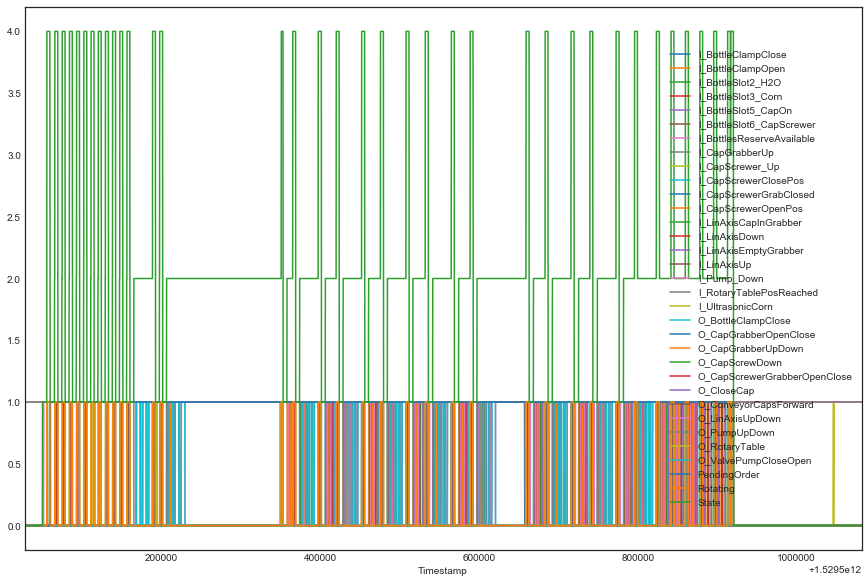

In [35]:
fig, ax = plt.subplots(figsize=(15, 10))
df1[low_mean_cols].plot(ax=ax)
plt.show()

In [36]:
# these are the high mean columns
high_mean_cols = set(df1.columns).difference(low_mean_cols)
high_mean_cols

{'BottleSlot1',
 'BottleSlot2_H2O',
 'BottleSlot3_Corn',
 'BottleSlot5_CapOn',
 'BottleSlot6_CapCloser',
 'BottleSlot8_ModuleOut',
 'BottlesAvailable',
 'BottlesNotUsed',
 'I_UltrasonicCorn_Distance',
 'I_UltrasonicH2O_Distance',
 'UltraSonic_Corn.DistanceM',
 'UltraSonic_H2O.DistanceM'}

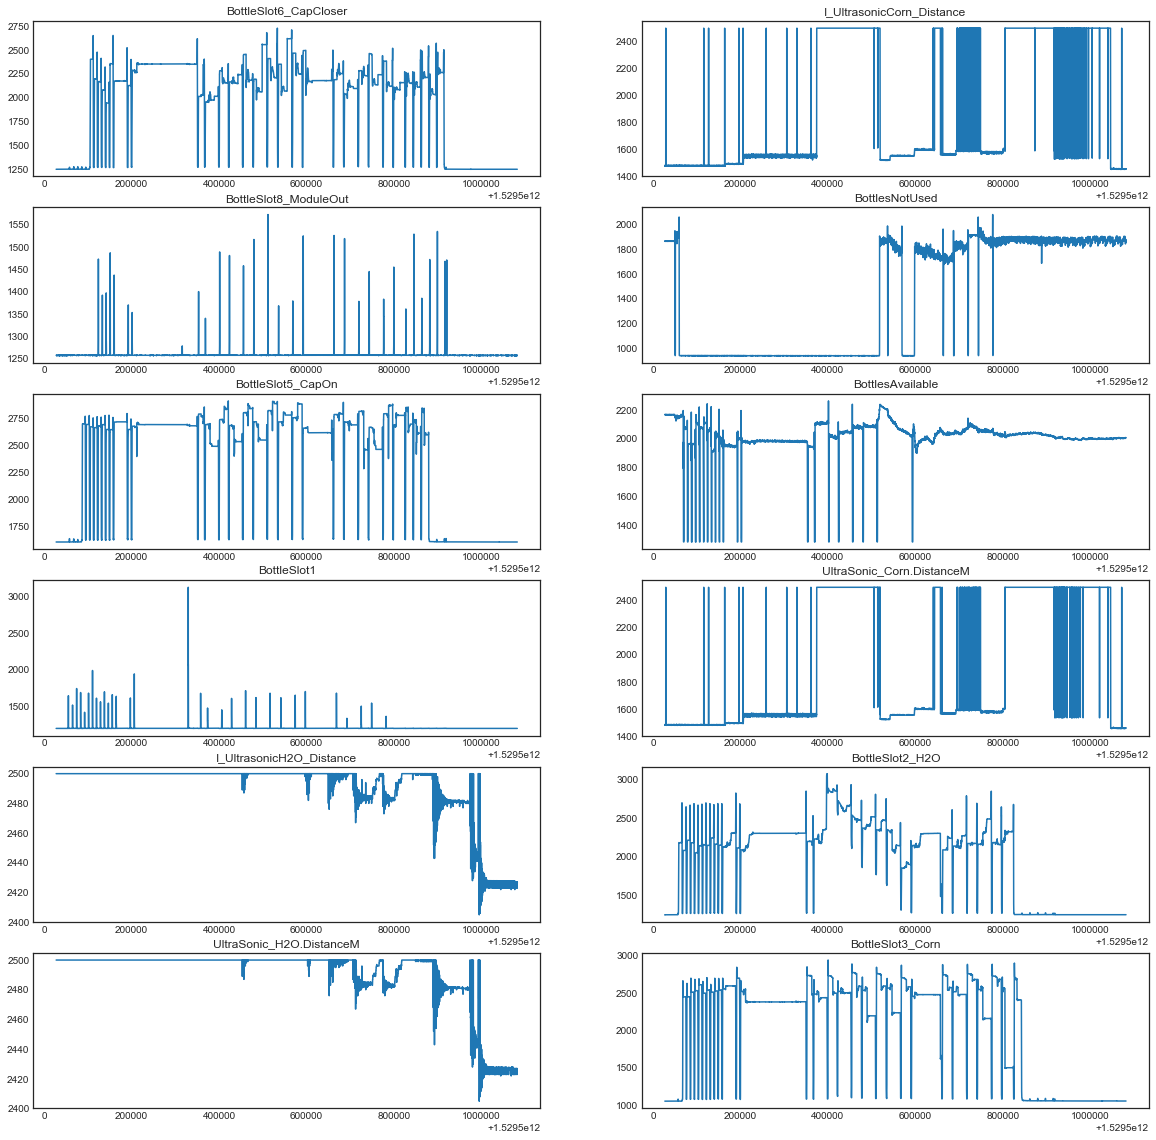

In [37]:
fig, axes = plt.subplots(nrows=len(high_mean_cols)//2, ncols=2, figsize=(20, 20))
axes = axes.flatten()
for ax, column in zip(axes, high_mean_cols):
    ax.plot(df1[column])
    ax.set(title=column)
plt.show()

In [38]:
# pick one of the variables to do anomaly detection
series = 'BottlesNotUsed'

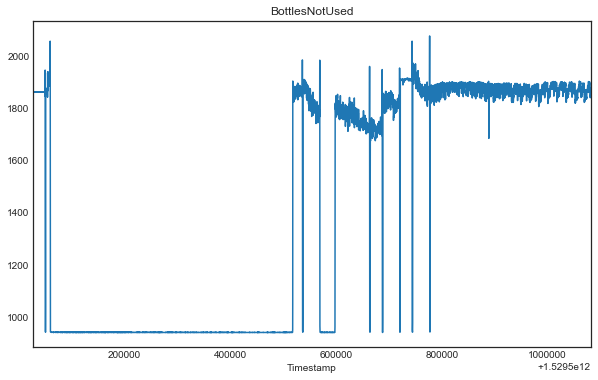

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))
df1[series].plot(ax=ax)
ax.set(title=series)
plt.show()

C:\Users\issohl\.conda\envs\diec\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\issohl\.conda\envs\diec\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


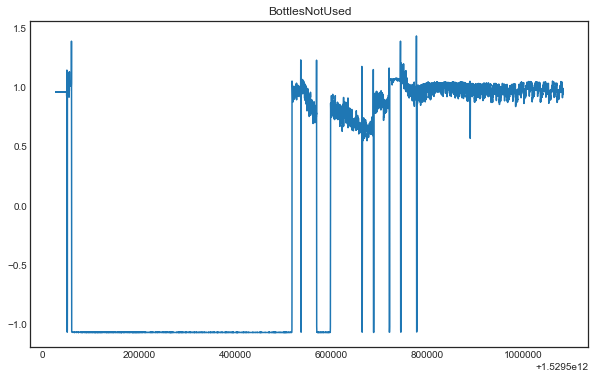

In [40]:
# scale and plot again
scaler = StandardScaler()
scaled_df1 = scaler.fit_transform(df1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df1.index, scaled_df1[:, df1.columns == series])
ax.set(title=series)
plt.show()

## Featurizing

To create features from a time series, we typically create windowed versions of each series.

For example:
x[t] becomes x[t-2], x[t-1], x[t], if the window is 3. This will create 3 columns instead of 1 column, and capture the history of the time series.

If there are multiple series, windowed versions of each series can be appended as new columns.

One way to think about this is that time adds another dimension, and that dimension is represented as new columns for the same feature.

In [41]:
df_series = pd.DataFrame(scaled_df1[:, df1.columns == series])
df_series.head()

,0
0,0.962853
1,0.962853
2,0.962853
3,0.962853
4,0.960656


In [42]:
df_series.shift(-1).head() # shift up by 1

,0
0,0.962853
1,0.962853
2,0.962853
3,0.960656
4,0.962853


In [88]:
def make_windowed_dataframe(array, window_size):
    """Returns a dataframe containing windowed versions of a series"""
    result = pd.concat([pd.DataFrame(array).shift(-i) for i in range(window_size)], axis=1)
    result.columns = [f't+{i}' for i in range(window_size)]
    result.dropna(inplace=True)
    return result

make_windowed_dataframe(scaled_df1[:, df1.columns == series], 5).head()

,t+0,t+1,t+2,t+3,t+4
0,0.962853,0.962853,0.962853,0.962853,0.960656
1,0.962853,0.962853,0.962853,0.960656,0.962853
2,0.962853,0.962853,0.960656,0.962853,0.962853
3,0.962853,0.960656,0.962853,0.962853,0.960656
4,0.960656,0.962853,0.962853,0.960656,0.962853


## Model

We will use the VAE example from Keras:
https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py

The reconstruction loss can be used to detect anomalies.

Other VAE examples:
- https://www.kaggle.com/hone5com/fraud-detection-with-variational-autoencoder

In [82]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.utils import plot_model
from keras import backend as K
from keras.losses import mse

class VAE:
    def __init__(self, original_dim, intermediate_dim, latent_dim):
        """Creates a variational autoencoder for continuous values
        """
        input_shape = (original_dim,)
        
        # VAE model = encoder + decoder
        # build encoder model
        inputs = Input(shape=input_shape, name='encoder_input')
        x = Dense(intermediate_dim, activation='relu')(inputs)
        x = Dense(intermediate_dim, activation='relu')(x)
        z_mean = Dense(latent_dim, name='z_mean')(x)
        z_log_var = Dense(latent_dim, name='z_log_var')(x)
        
        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(VAE.sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
        
        # instantiate encoder model
        self.encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
        
        # build decoder model
        latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
        x = Dense(intermediate_dim, activation='relu')(latent_inputs)
        x = Dense(intermediate_dim, activation='relu')(x)
        outputs = Dense(original_dim, activation='sigmoid')(x)

        # instantiate decoder model
        self.decoder = Model(latent_inputs, outputs, name='decoder')

        # instantiate VAE model
        outputs = self.decoder(self.encoder(inputs)[2])
        self.vae = Model(inputs, outputs, name='vae_mlp')
        
         # VAE loss = mse_loss + kl_loss
        reconstruction_loss = mse(inputs, outputs)
        reconstruction_loss *= original_dim
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        self.vae.add_loss(vae_loss)
                 
    def describe(self):
        """Display model summaries and architectures"""
        self.encoder.summary()
        plot_model(self.encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
        self.decoder.summary()
        plot_model(self.decoder, to_file='vae_mlp_decoder.png', show_shapes=True)
        self.vae.summary()
        plot_model(self.vae, to_file='vae_mlp.png', show_shapes=True)
    
    def fit(self, X, optimizer='adam', **kwargs):
        """Fits the model"""
        self.vae.compile(optimizer=optimizer)
        return self.vae.fit(X, **kwargs)
    
    # reparameterization trick
    # instead of sampling from Q(z|X), sample epsilon = N(0,I)
    # z = z_mean + sqrt(var) * epsilon
    def sampling(args):
        """Reparameterization trick by sampling from an isotropic unit Gaussian.
        # Arguments
            args (tensor): mean and log of variance of Q(z|X)
        # Returns
            z (tensor): sampled latent vector
        """

        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean = 0 and std = 1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [101]:
window_size = 50

In [102]:
model = VAE(original_dim=window_size, intermediate_dim=window_size//2, latent_dim=window_size//8)
model.describe()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 50)           0                                            
__________________________________________________________________________________________________
dense_69 (Dense)                (None, 25)           1275        encoder_input[0][0]              
__________________________________________________________________________________________________
dense_70 (Dense)                (None, 25)           650         dense_69[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 6)            156         dense_70[0][0]                   
__________________________________________________________________________________________________
z_log_var 

### Encoder:
![encoder](./vae_mlp_encoder.png)

### Decoder:
![decoder](./vae_mlp_decoder.png)

### VAE:
![vae](./vae_mlp.png)

### Training

In [89]:
x = scaled_df1[:, df1.columns == series]
x_train, x_test = train_test_split(x, shuffle=False, train_size=5000)

print(x_train.shape, x_test.shape)

(5000, 1) (5529, 1)


C:\Users\issohl\.conda\envs\diec\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


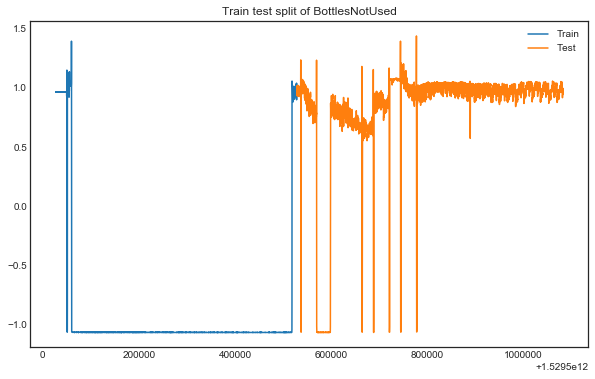

In [90]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df1.index[:x_train.shape[0]], x_train, label='Train')
ax.plot(df1.index[x_train.shape[0]:], x_test, label='Test')
ax.set(title=f'Train test split of {series}')
ax.legend()
plt.show()

In [103]:
X_train = make_windowed_dataframe(x_train, window_size) # series vector to windowed matrix
X_test = make_windowed_dataframe(x_test, window_size) # series vector to windowed matrix

print(X_train.shape, X_test.shape)

(4951, 50) (5480, 50)


In [104]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=2)
hist = model.fit(X_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[es])

Train on 4455 samples, validate on 496 samples
Epoch 1/50
4455/4455 [==============================] - 2s 411us/step - loss: 78.7607 - val_loss: 56.2042
Epoch 2/50
4455/4455 [==============================] - 1s 120us/step - loss: 56.9942 - val_loss: 53.5882
Epoch 3/50
4455/4455 [==============================] - 1s 119us/step - loss: 55.5268 - val_loss: 52.1084
Epoch 4/50
4455/4455 [==============================] - 1s 119us/step - loss: 54.7827 - val_loss: 51.7571
Epoch 5/50
4455/4455 [==============================] - 1s 119us/step - loss: 54.3759 - val_loss: 51.7422
Epoch 6/50
4455/4455 [==============================] - 1s 123us/step - loss: 54.2094 - val_loss: 51.3853
Epoch 7/50
4455/4455 [==============================] - 1s 120us/step - loss: 54.1311 - val_loss: 51.1633
Epoch 8/50
4455/4455 [==============================] - 1s 120us/step - loss: 54.0704 - val_loss: 51.1460
Epoch 9/50
4455/4455 [==============================] - 1s 120us/step - loss: 54.0375 - val_loss: 51.1452

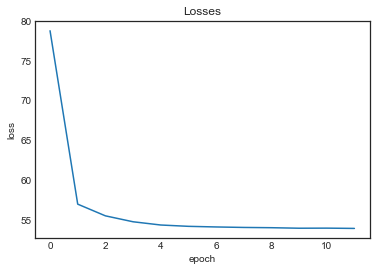

In [105]:
fig, ax = plt.subplots()
ax.plot(hist.history['loss'])
ax.set(title='Losses', xlabel='epoch', ylabel='loss')
plt.show()

### Anomaly Detection

In [ ]:
chunks = 500
num_chunks = y_test.shape[0] // chunks

fig, ax = plt.subplots(figsize=(10, 6))
for c in range(num_chunks-1):
    ax.plot(df1.index[y_train.shape[0]:][c*chunks:(c+1)*chunks], y_test[c*chunks:(c+1)*chunks])
ax.set(title=f'Test set in chunks of {chunks}')
plt.show()

In [ ]:
# cost for each section (whether an anomaly was detected)
costs = []
for c in range(num_chunks-1):
    test = y_test[c*chunks:(c+1)*chunks]
    cost = model.cost.eval(session=model.sess, feed_dict={model.input:test})
    print(cost)
    costs.append(cost)

In [ ]:
cost_scaler = StandardScaler()
costs_scaled = cost_scaler.fit_transform(np.array(costs).reshape(-1, 1))
costs_scaled

In [ ]:
is_anomaly = np.where(costs_scaled > 0, True, False)
is_anomaly

In [ ]:
chunks = 500
num_chunks = y_test.shape[0] // chunks

fig, ax = plt.subplots(figsize=(10, 6))
for c, anomaly in zip(range(num_chunks-1), is_anomaly):
    color = 'red' if anomaly else 'blue'
    ax.plot(df1.index[y_train.shape[0]:][c*chunks:(c+1)*chunks], y_test[c*chunks:(c+1)*chunks], color=color)

ax.set(title=f'Anomaly detection for {series}')
plt.show()